In [1]:
#导入模块
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from scipy.stats import norm

In [2]:
'''
sales_train.csv为训练集，包括字段：
date、date_block_num、shop_id、item_id、item_price、item_cnt_day。

items.csv、shops.csv、item_categories.csv均为对数据的补充信息，可以构造更加多维的特征
附加了item_name、item_id、item_category_id、item_category_name、item_category_id、shop_name、shop_id等字段

测试集仅包含ID、shop_id、item_id三个字段。各字段的解释如下：
字段名                              字段说明
ID                                  表示测试集中的（商店，项目）元组的ID
shop_id                             商店的唯一标识符
item_id                             产品的唯一标识符
item_category_id                    产品类别的唯一标识符
item_cnt_day                        销售的产品数量。您正在预测此度量的每月金额
item_price                          商品的当前价格
date                                日期（格式为dd / mm / yyyy）
date_block_num                      一个连续的月号，用于方便。2013年1月是0，2013年2月是1，…，2015年10月是33
item_name                           产品名称
shop_name                           商店名称
item_category_name                  项目类别的名称
'''
##读入数据，组成训练数据
print('train:')
test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32',
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv',dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32','item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('sales_train.csv', parse_dates=['date'],dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32',
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
#训练数据合并，按照列名合并，rsuffix即重合列合并
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
#查看训练数据
print(train.head().append(train.tail()))
#查看要预测的测试数据
print('test:')
print(test.head().append(test.tail()))

'''
date进行处理后，这里由于原始数据date列是02.01.2013这样的格式，在读取数据的时候之间转换成date型会将月份和日子调换，
所以这里的2013-02-01实际上是2013年1月2日，由于后面并没有用到这个date，而是用到用于月份计数的date_block_num，所以这里后期可以去掉parse_dates参数
'''

'''
可以看到训练数据一共有2935849个样本，10列原始特征列，记录的销量日期从2013年1月到2015年10月，而这里需要我们预测的是2015年11月的销量信息。
这里只读取1048575个样本（其余数据网站文件丢失了）
'''

train:
              date  date_block_num  shop_id  item_id   item_price  \
0       2013-02-01               0       59    22154   999.000000   
1       2013-03-01               0       25     2552   899.000000   
2       2013-05-01               0       25     2552   899.000000   
3       2013-06-01               0       25     2554  1709.050049   
4       2013-01-15               0       25     2555  1099.000000   
1048570 2013-07-11              10       37    18474   199.000000   
1048571 2013-11-18              10       37    18474   199.000000   
1048572 2013-11-24              10       37    18484   199.000000   
1048573 2013-11-11              10       37    19751    99.000000   
1048574 2013-11-26              10       37    18498   199.000000   

         item_cnt_day                                 item_name  \
0                   1                         ЯВЛЕНИЕ 2012 (BD)   
1                   1  DEEP PURPLE  The House Of Blue Light  LP   
2                  -1  DEEP PURP

'\n可以看到训练数据一共有2935849个样本，10列原始特征列，记录的销量日期从2013年1月到2015年10月，而这里需要我们预测的是2015年11月的销量信息。\n这里只读取1048575个样本（其余数据网站文件丢失了）\n'

In [6]:
#EDA：数据探索分析
'''
何为EDA，何谓探索性数据分析？英文名为Exploratory Data Analysis，是在你拿到数据集后，并不能预知能从数据集中找到什么
但又需要了解数据的基本情况，为了后续更好地预处理数据、特征工程乃至模型建立。因此探索性数据分析，对了解数据集、了解变量之间对相互关系
以及变量与预测值之间的关系尤其重要。

分：数据质量分析和数据特征分析
'''

##数据质量分析

#1.一致性分析：被挖掘数据来自于不同的数据源、对于重复存放的数据未能进行一致性更新造成的
print('一致性分析'+'**'*10)
# -->数据泄漏
'''
从测试集可以看出，测试集只有shop_id和item_id，且行数少于训练集行数，考虑模型只训练测试集所包含的（shop_id,item_id）对，其他的匹配对不予以考虑
'''
#获取测试集中有的产品id商店id
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
#训练集中只用测试集中的产品来训练，其余不要
lk_train = train[train['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]
#字符型特征值不要，只留下数值型
train_monthly = lk_train[
    ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
print('一致性处理:')
print(train_monthly.head().append(train_monthly.tail()))
print('**'*30)


一致性分析********************
一致性处理:
              date  date_block_num  shop_id  item_category_id  item_id  \
0       2013-02-01               0       59                37    22154   
10      2013-03-01               0       25                55     2574   
11      2013-05-01               0       25                55     2574   
12      2013-07-01               0       25                55     2574   
13      2013-08-01               0       25                55     2574   
1048567 2013-11-14              10       37                55    18466   
1048568 2013-11-28              10       37                55    18466   
1048572 2013-11-24              10       37                55    18484   
1048573 2013-11-11              10       37                40    19751   
1048574 2013-11-26              10       37                55    18498   

         item_price  item_cnt_day  
0             999.0             1  
10            399.0             2  
11            399.0             1  
12      

重复值情况：
False
************************************************************
缺失值分析********************
基本情况
       date_block_num        shop_id  item_category_id        item_id  \
count   216309.000000  216309.000000     216309.000000  216309.000000   
mean         4.957404      31.498643         41.309058    9430.114152   
std          2.965745      16.180127         17.607409    6356.122750   
min          0.000000       2.000000          2.000000      30.000000   
25%          2.000000      19.000000         30.000000    3732.000000   
50%          5.000000      31.000000         40.000000    7856.000000   
75%          8.000000      45.000000         55.000000   15045.000000   
max         10.000000      59.000000         83.000000   22167.000000   

          item_price   item_cnt_day  
count  216309.000000  216309.000000  
mean      731.012268       1.416483  
std       783.541626       2.663779  
min         3.000000      -6.000000  
25%       249.000000       1.000000  
50%      

A:\Anaconda3\lib\site-packages\seaborn\matrix.py:287: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
A:\Anaconda3\lib\site-packages\seaborn\matrix.py:287: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
A:\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:2885: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([dvw, 0])


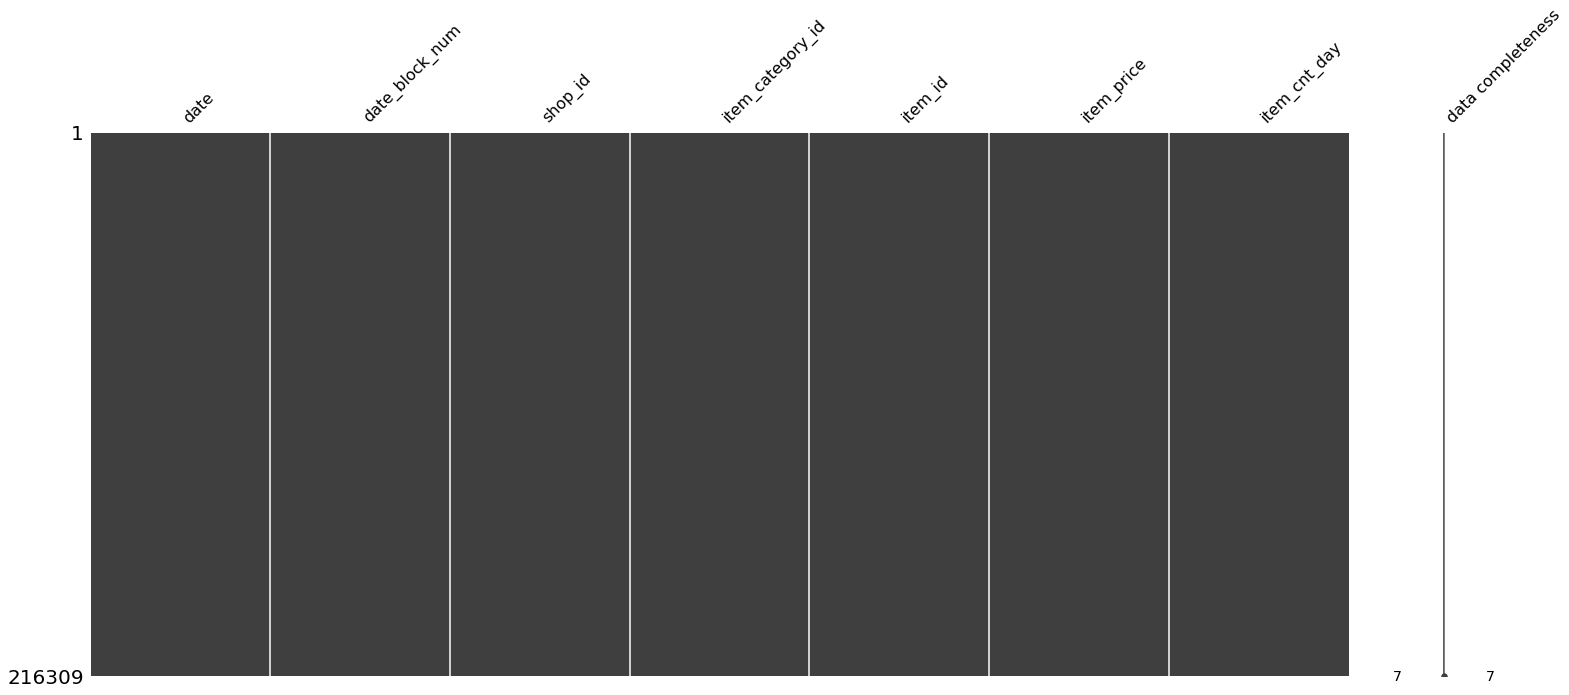

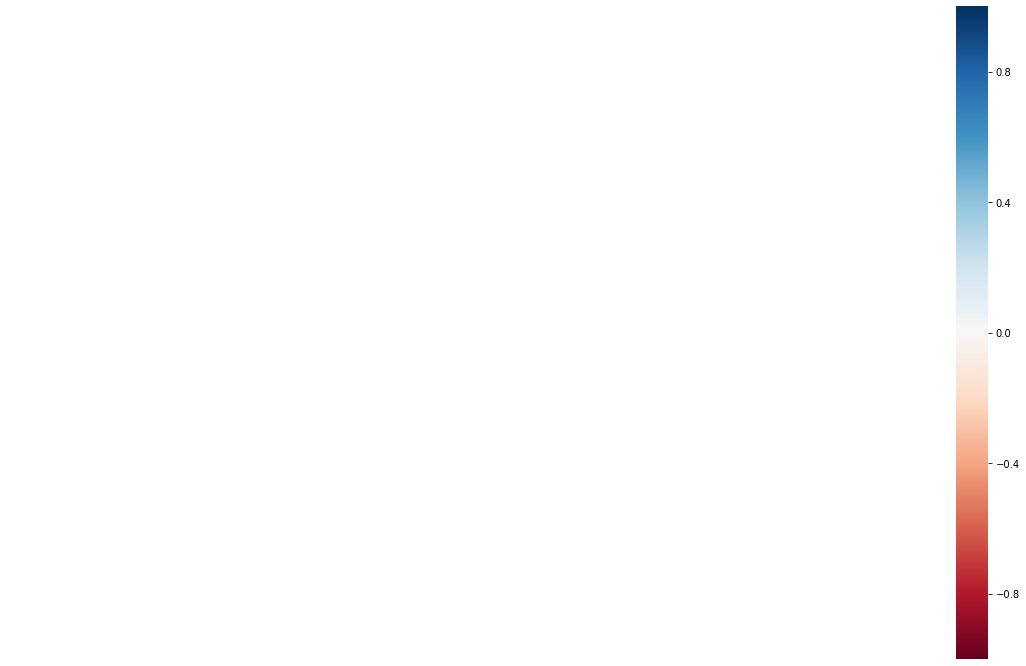

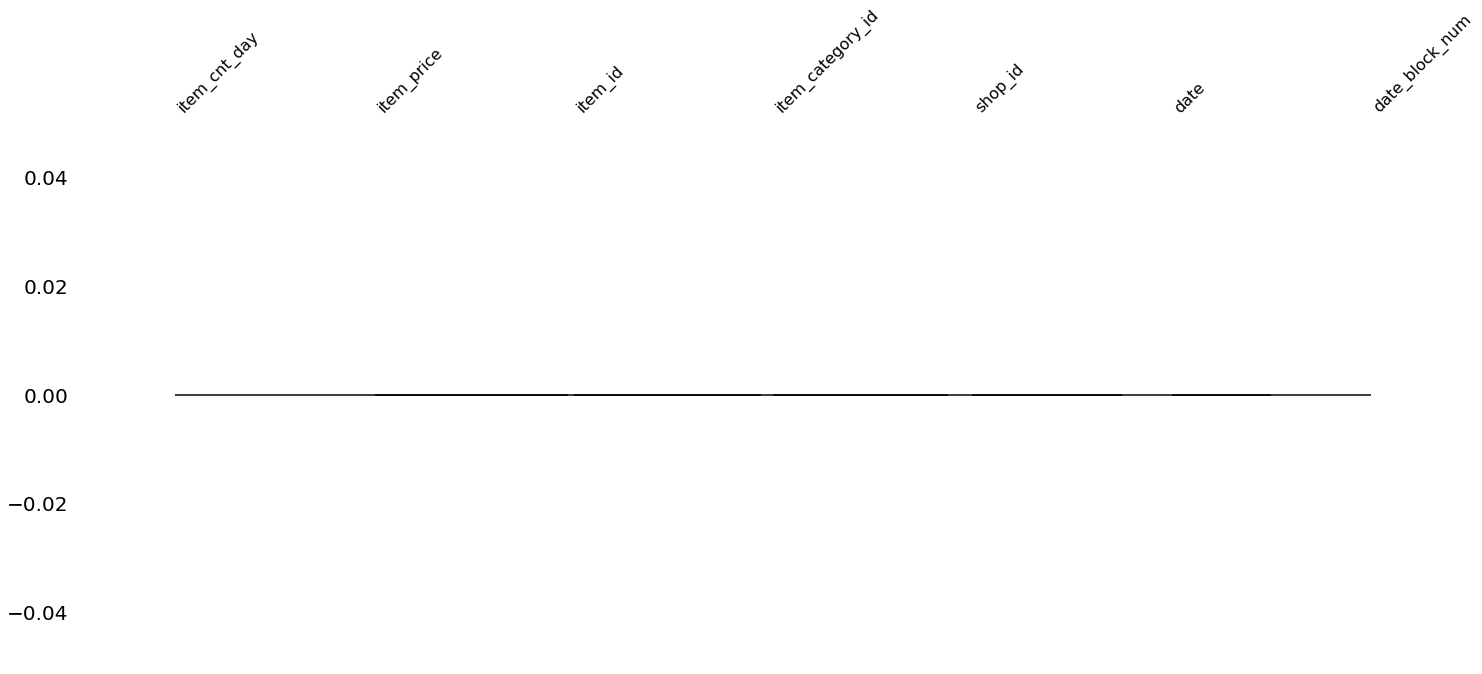

In [4]:
#2.缺失值与重复值分析：

#--》重复值（一般采取删除措施）
print('重复值情况：')
print(train_monthly.duplicated().any())#重复值的发现，false代表没有重复值
print('**'*30)
##删去重复值(若有,这里没有)
#train_monthly=train_monthly.drop_duplicates()
#print('删除重复值后：')
#print(train_monthly.duplicated().any())

#--》缺失值
print('缺失值分析'+'**'*10)
'''
缺失值类型
1、随机丢失（MAR，Missing at Random）
指数据丢失的概率与丢失的数据本身无关，而仅与部分已观测到的数据有关。
2、完全随机丢失（MCAR，Missing Completely at Random）
数据的缺失是完全随机的，不依赖于任何不完全变量或完全变量，不影响样本的无偏性。
3、非随机丢失（MNAR，Missing not at Random）
数据的缺失与不完全变量自身的取值有关。
'''
#STEP 1:看数据基本情况
print('基本情况')
print(train_monthly.describe())
#STEP 2:统计缺失值
print('缺失值统计')
missing=train_monthly.isnull().sum().reset_index().rename(columns={0:'missNum'})
print(missing)
#STEP 3:计算缺失值比例
print('缺失值比例')
missing['missRate']=missing['missNum']/train_monthly.shape[0]
print(missing)
#STEP 4:按照缺失率排序显示
print('缺失率排序显示')
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
print(miss_analy)

#STEP 5：缺失值可视化
def tiaoxingtu():
    colors = ['DeepSkyBlue' ,'DeepPink', 'Yellow', 'LawnGreen' ,'Aqua', 'DarkSlateGray']
    fig = plt.figure(figsize=(20,6))
    plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',color=colors)
    font = {'family' : 'Times New Roman','weight' : 'normal','size' : 23,}
    plt.title('Histogram of missing value of variables',fontsize=20)
    plt.xlabel('variables names',font)
    plt.ylabel('missing rate',font)
    # 添加x轴标签，并旋转90度
    plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
    plt.xticks(rotation=90)
    # 添加数值显示
    for x,y in enumerate(list(miss_analy.missRate.values)):
        plt.text(x,y+0.08,'{:.2%}'.format(y),ha='center',rotation=90)
        plt.ylim([0,1.2])
    # 保存图片
    fig.savefig('missing.png')
    plt.show()
def juzhentu():
    msno.matrix(train_monthly,labels=True)
def tiaoxingtu2():
    msno.bar(train_monthly)
def retu():
    msno.heatmap(train_monthly)
def shuzhuangtu():
    msno.dendrogram(train_monthly)
print('矩阵图')
juzhentu()
#print('缺失值条形图') 其实条形图和矩阵图差不多，就不过多展示
#tiaoxingtu2()
print('热力图')
retu()
print('树状图')
shuzhuangtu()
#STEP 6:缺失值处理
#丢弃
train_monthly.dropna()#删除空值
'''
train_monthly.drop('date',axis=1,inplace=True) 删除date列
train_monthly.dropna(axis=0,subset=['date','date_block_num'],inplace=True) 删除date、date_block_num列有缺失值的行
train_monthly.dropna(thresh=len(train_monthly)*0.2,axis=1) 删除缺失值比例大于80%以上的变量
'''
#补全   一般缺失占比少，在10-30%，利用模型填补
def chazhi():
    # interpolate()插值法，缺失值前后数值的均值，但是若缺失值前后也存在缺失，则不进行计算插补。
    train_monthly['date'] = train_monthly['date'].interpolate()
    # 用前面的值替换, 当第一行有缺失值时，该行利用向前替换无值可取，仍缺失
    train_monthly.fillna(method='pad')
    # 用后面的值替换，当最后一行有缺失值时，该行利用向后替换无值可取，仍缺失
    train_monthly.fillna(method='backfill') # 用后面的值替换
def duochongchabu():
    '''
    常见插值函数：牛顿插值法、分段插值法、样条插值法、Hermite插值法、埃尔米特插值法和拉格朗日插值法
    以下详细介绍拉格朗日插值法的原理和使用。
    '''
    from scipy.interpolate import lagrange #引用其他函数都可以，这个库里面都有
    x=[1,2,3,4,7]
    y=[5,7,10,3,9]
    f=lagrange(x,y)
    print(f)
    '''
    4 3 2
    0.5472 x - 7.306 x + 30.65 x - 47.03 x + 28.13
    # 第一行和第二行就是插值的结果，显示出的函数。第二行的数字是对应下午的x的幂
    '''
    print(f(1),f(2),f(3))
    '''
    5.000000000000007 7.000000000000014 10.00000000000005
    # 此行是代入的x值，得到的结果。即用小括号f(x)的这种形式，可以直接得到计算结果。\
    '''
    print(f[0],f[2],f[3])
    '''
    28.13333333333334 30.65277777777778 -7.3055555555555545
    # 此行是提取出的系数。即可以用f[a]这种形式，来提取出来对应幂的系数。
    '''
def knn(X_train, y_train, X_test, k=3, dispersed=True):
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    '''
    :params: X_train 为目标列中不含缺失值的数据（不包括目标列）
    :params: y_train 为不含缺失值的目标标签
    :params: X_test 为目标列中为缺失值的数据（不包括目标列）
    '''
    if dispersed:
        KNN = KNeighborsClassifier(n_neighbors=k, weights="distance")
    else:
        KNN = KNeighborsRegressor(n_neighbors=k, weights="distance")
    KNN.fit(X_train, y_train)
    return X_test.index, KNN.predict(X_test)
def random_forest(X_train, y_train, X_test, k = 3, dispersed = True): #常用
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    '''
    :params: X_train 为目标列中不含缺失值的数据（不包括目标列）
    :params: y_train 为不含缺失值的目标标签
    :params: X_test 为目标列中为缺失值的数据（不包括目标列）
    '''
    if dispersed:
        rf = RandomForestRegressor()
    else:
        rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    return X_test.index, rf.predict(X_test)  
#占比在10%一下，用数学方法即可
def shuxue():
    # 均值填充
    train_monthly['date'] = train_monthly['date'].fillna(train_monthly['date'].means())
    # 中位数填充
    train_monthly['date'] = train_monthly['date'].fillna(train_monthly['date'].median())
    # 众数填充
    train_monthly['date'] = train_monthly['date'].fillna(stats.mode(train_monthly['date'])[0][0])



异常值分析********************
       date_block_num        shop_id  item_category_id        item_id  \
count   216309.000000  216309.000000     216309.000000  216309.000000   
mean         4.957404      31.498643         41.309058    9430.114152   
std          2.965745      16.180127         17.607409    6356.122750   
min          0.000000       2.000000          2.000000      30.000000   
25%          2.000000      19.000000         30.000000    3732.000000   
50%          5.000000      31.000000         40.000000    7856.000000   
75%          8.000000      45.000000         55.000000   15045.000000   
max         10.000000      59.000000         83.000000   22167.000000   

          item_price   item_cnt_day  
count  216309.000000  216309.000000  
mean      731.012268       1.416483  
std       783.541626       2.663779  
min         3.000000      -6.000000  
25%       249.000000       1.000000  
50%       449.000000       1.000000  
75%       999.000000       1.000000  
max     5920

A:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'boxplot')

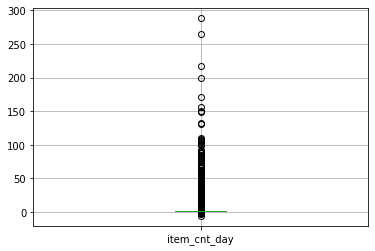

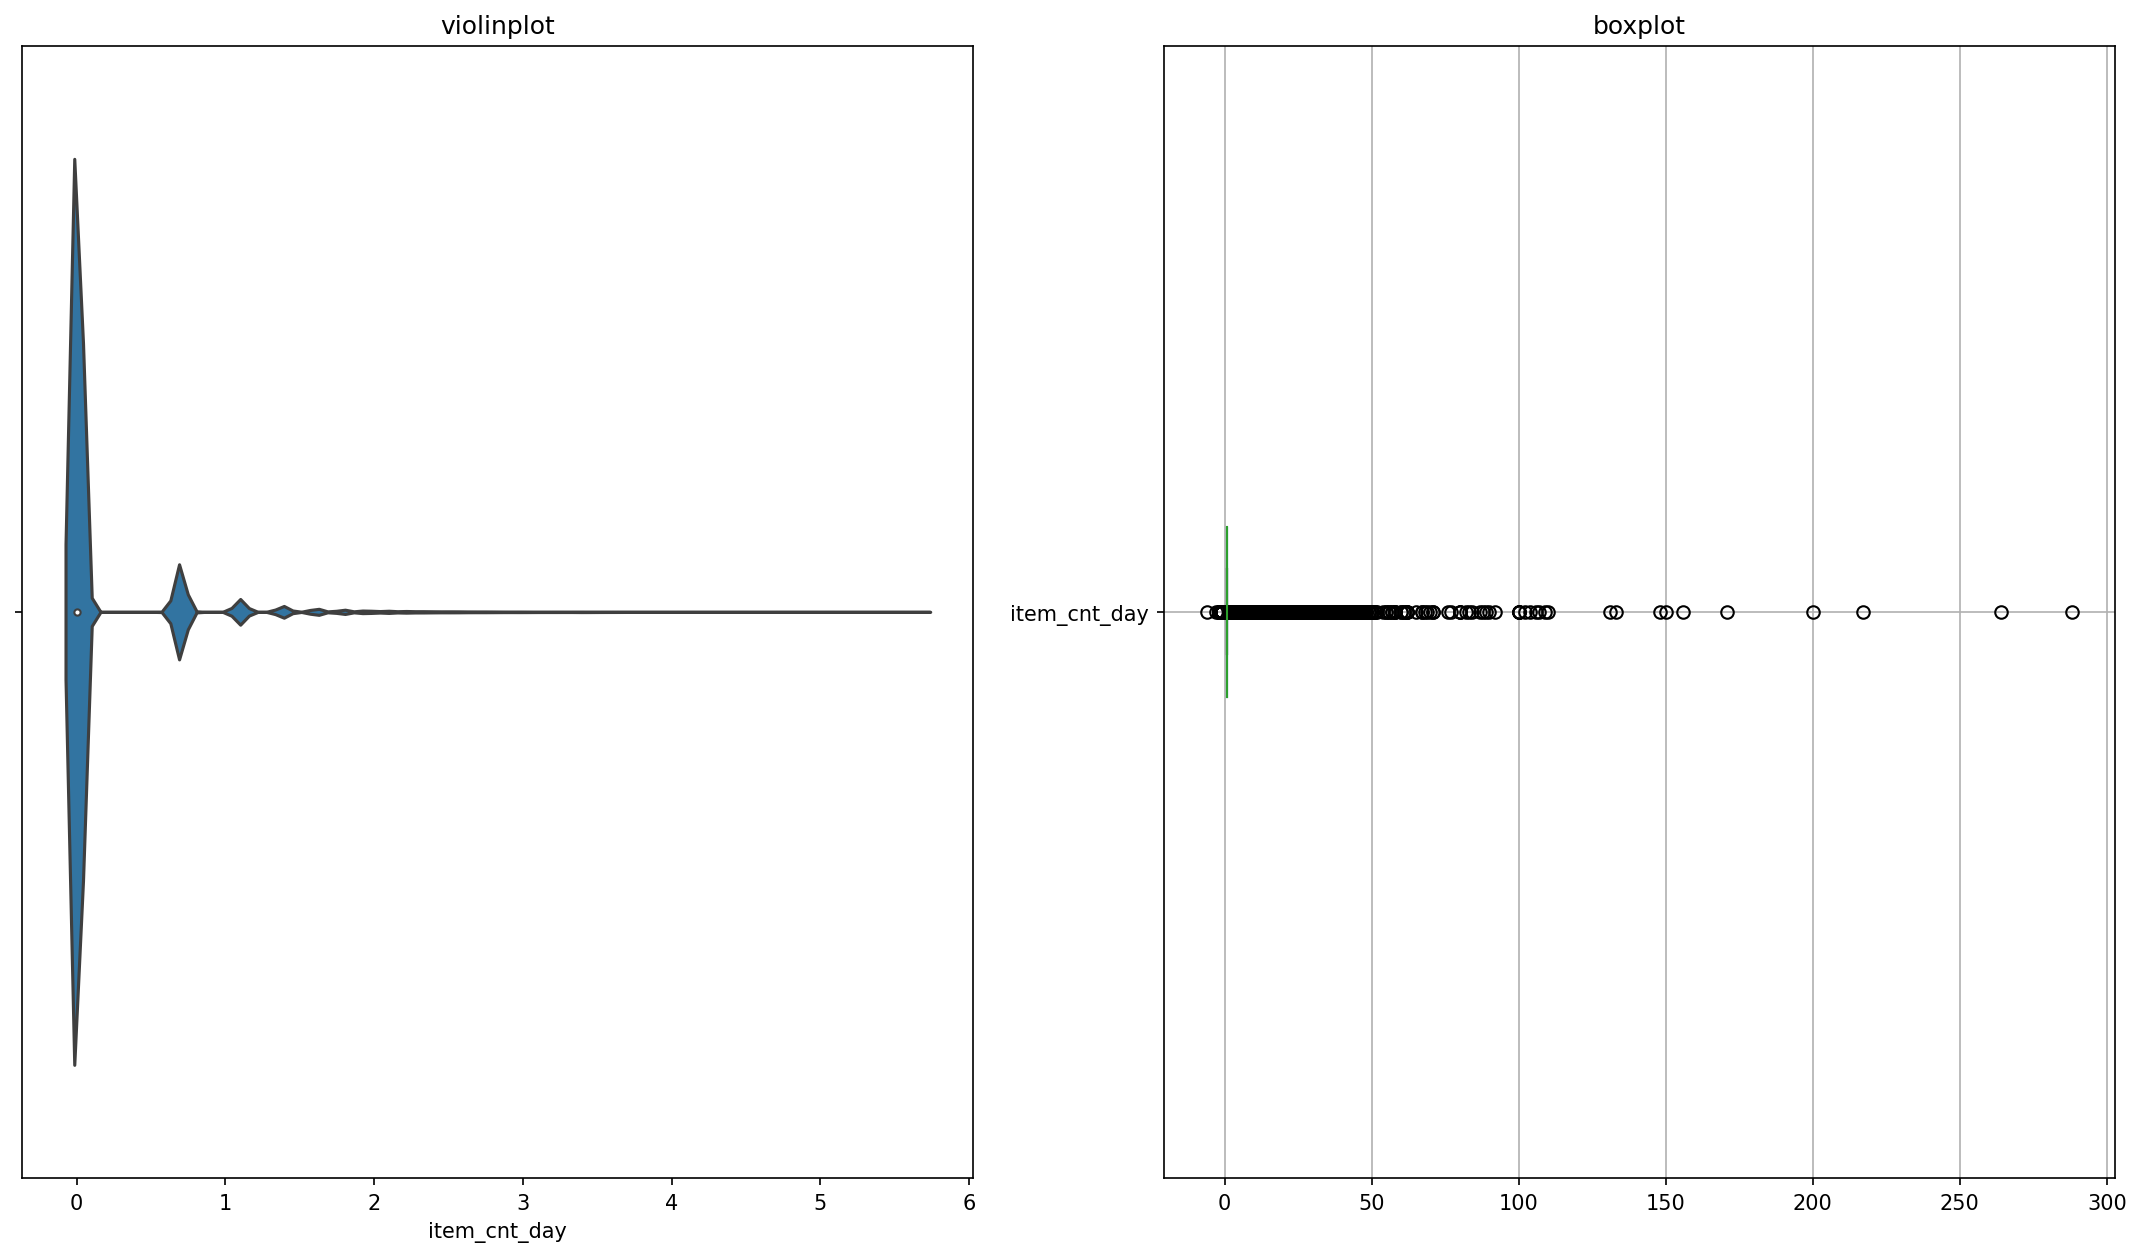

In [5]:
#3.异常值分析：
print('异常值分析'+'**'*10)
#STEP 1:简单统计量分析，可根据3个标准差来判断异常值
print(train_monthly.describe())
#STEP 2:箱型图分析
train_monthly.loc[:,['item_cnt_day']].boxplot() #针对item_cnt_day这一个变量来看异常值
#STEP 3:小提琴图看异常值
# 小提琴图与箱型图对比
plt.figure(figsize=(18,10), dpi=150)
plt.subplot(1,2,1)
sns.violinplot(np.log(train_monthly['item_cnt_day']))
plt.title('violinplot')
plt.subplot(1,2,2)
train_monthly.loc[:, ['item_cnt_day']].boxplot(vert=False)
plt.title('boxplot')

In [6]:
##数据特征分析
'''
对数据进行质量分析后，通过绘制图表、计算某些特征量等手段进行数据的特征分析。

从五个角度出发，利用统计指标对定量数据进行统计描述。常用集中趋势和离散程度（离中趋势）

总体规模的描述 ---- 总量指标
分布形态的描述 ---- 偏态与峰态
对比关系的描述 ---- 相对指标
集中趋势的描述 ---- 平均指标
离散程度的描述 ---- 变异指标
'''


##为方便后续eda,按照月份，商店和商品来计算出销量和价格的总值和均值
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'],
                                                          as_index=False) #groupby as_index:聚合条件是否作为index输出
train_monthly = train_monthly.agg({'item_price': ['sum', 'mean'], 'item_cnt_day': ['sum', 'mean', 'count']}) #Pandas中的的agg ()函数为aggregate的缩写，总数、合计、聚合的意思，是一个功能非常强大的函数，在Pandas中可以利用agg ()对 Series 、 DataFrame 以及 groupby () 后的结果进行聚合操作。
# 特征重命名.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price',
                         'item_cnt', 'mean_item_cnt', 'transactions']
print('按月份统计后：')
print(train_monthly.head().append(train_monthly.tail()))


#考虑到测试集可能会有不同的商店和商品的组合，这里我们对训练数据按照shop_id和item_id的组合进行扩充，缺失数据进行零填充
#同时构造出具体的年，月信息：对训练数据按照shop_id和item_id的组合进行扩充，缺失数据进行零填充，同时构造出具体的年，月信息
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(10):  #这个i是data_block_num的最大值
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])

empty_df = pd.DataFrame(empty_df, columns=['date_block_num', 'shop_id', 'item_id'])

train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num', 'shop_id', 'item_id'], how='left') #merge:链接合并函数

train_monthly.fillna(0, inplace=True)

train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x // 12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))
print('组合扩充：')
print(train_monthly.head().append(train_monthly.tail()))

按月份统计后：
       date_block_num  shop_id  item_category_id  item_id    item_price  \
0                   0        2                 2     5572  10730.000000   
1                   0        2                 2     5643   4775.209961   
2                   0        2                 5     5583   1188.300049   
3                   0        2                 6     7893   5970.000000   
4                   0        2                 6     7894   1490.000000   
97813              10       44                55     1247    299.000000   
97814              10       44                55     1249    598.000000   
97815              10       44                60     1142   1999.000000   
97816              10       44                67     1007    599.000000   
97817              10       44                67     1010    299.000000   

       mean_item_price  item_cnt  mean_item_cnt  transactions  
0          1532.857178         9       1.285714             7  
1          2387.604980         0      

**********分组完毕**********


Text(0.5, 1.0, 'Monthly sum')

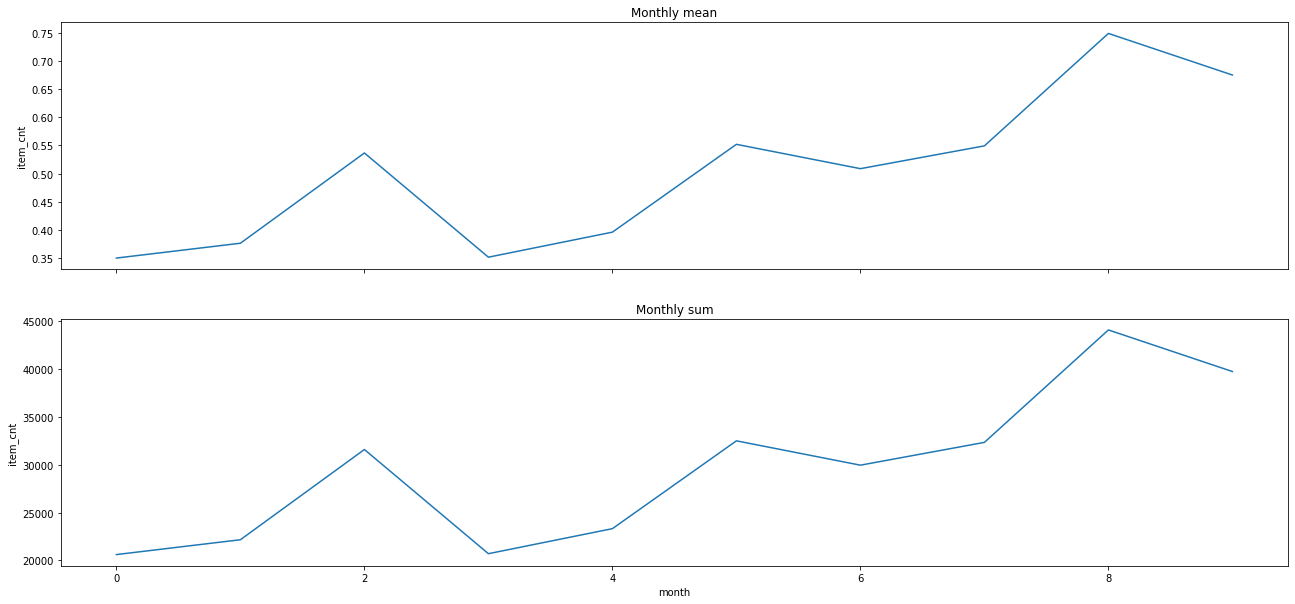

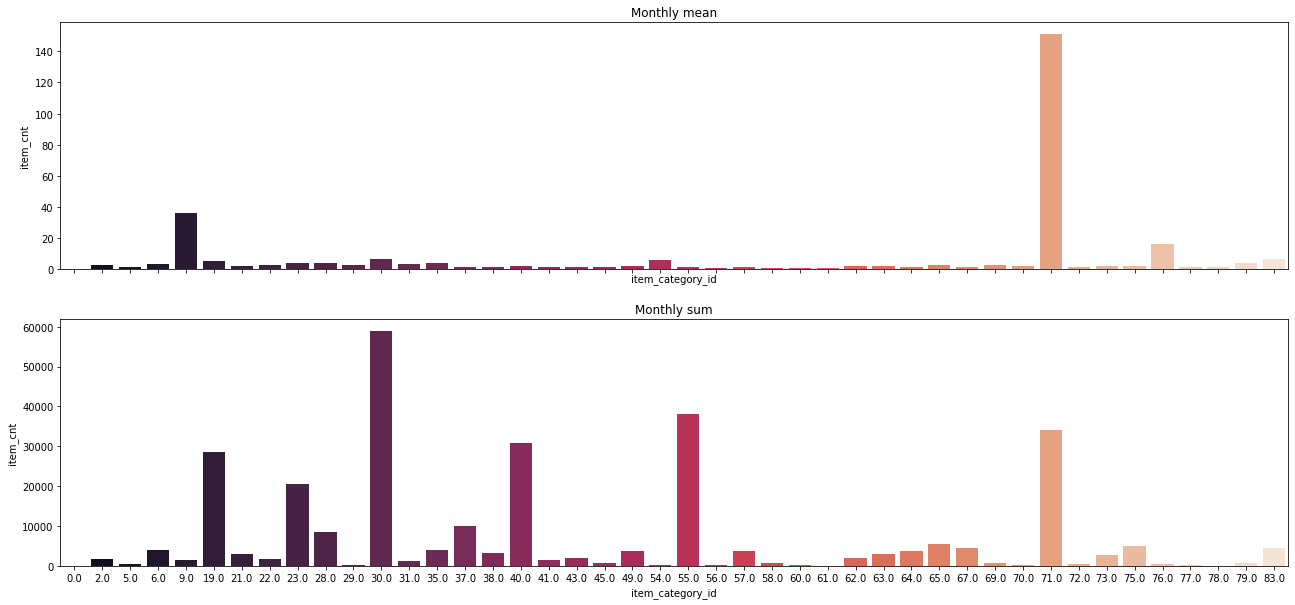

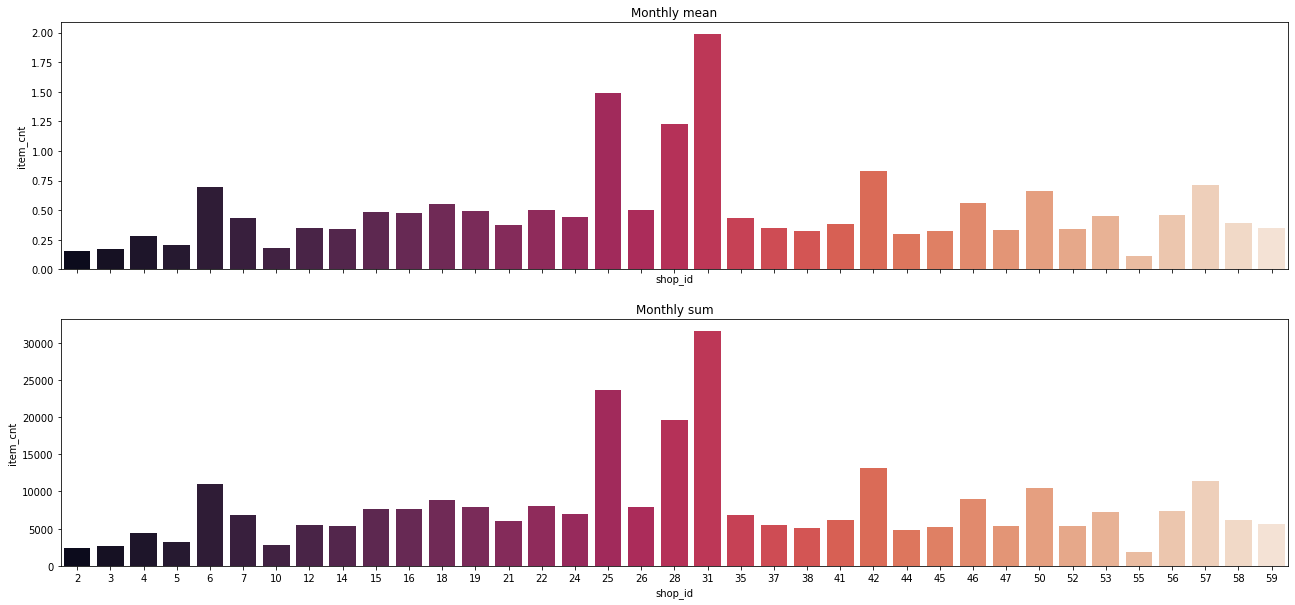

In [7]:
#1.总体规模的描述

##分别按照month,category和shop分组，得到各组的销量
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

print("**********分组完毕**********")

##分别查看各组和销量之间的关系曲线
##月份与销量
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
#plt.savefig("月份与销量.png")
#plt.close()

##种类与销量
m, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
#plt.savefig("种类与销量.png")
#plt.close()

##商店与销量
n, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
#plt.savefig("商店与销量.png")
#plt.close()


频率分布直方图


Text(0.5, 1.0, 'item_category_id')

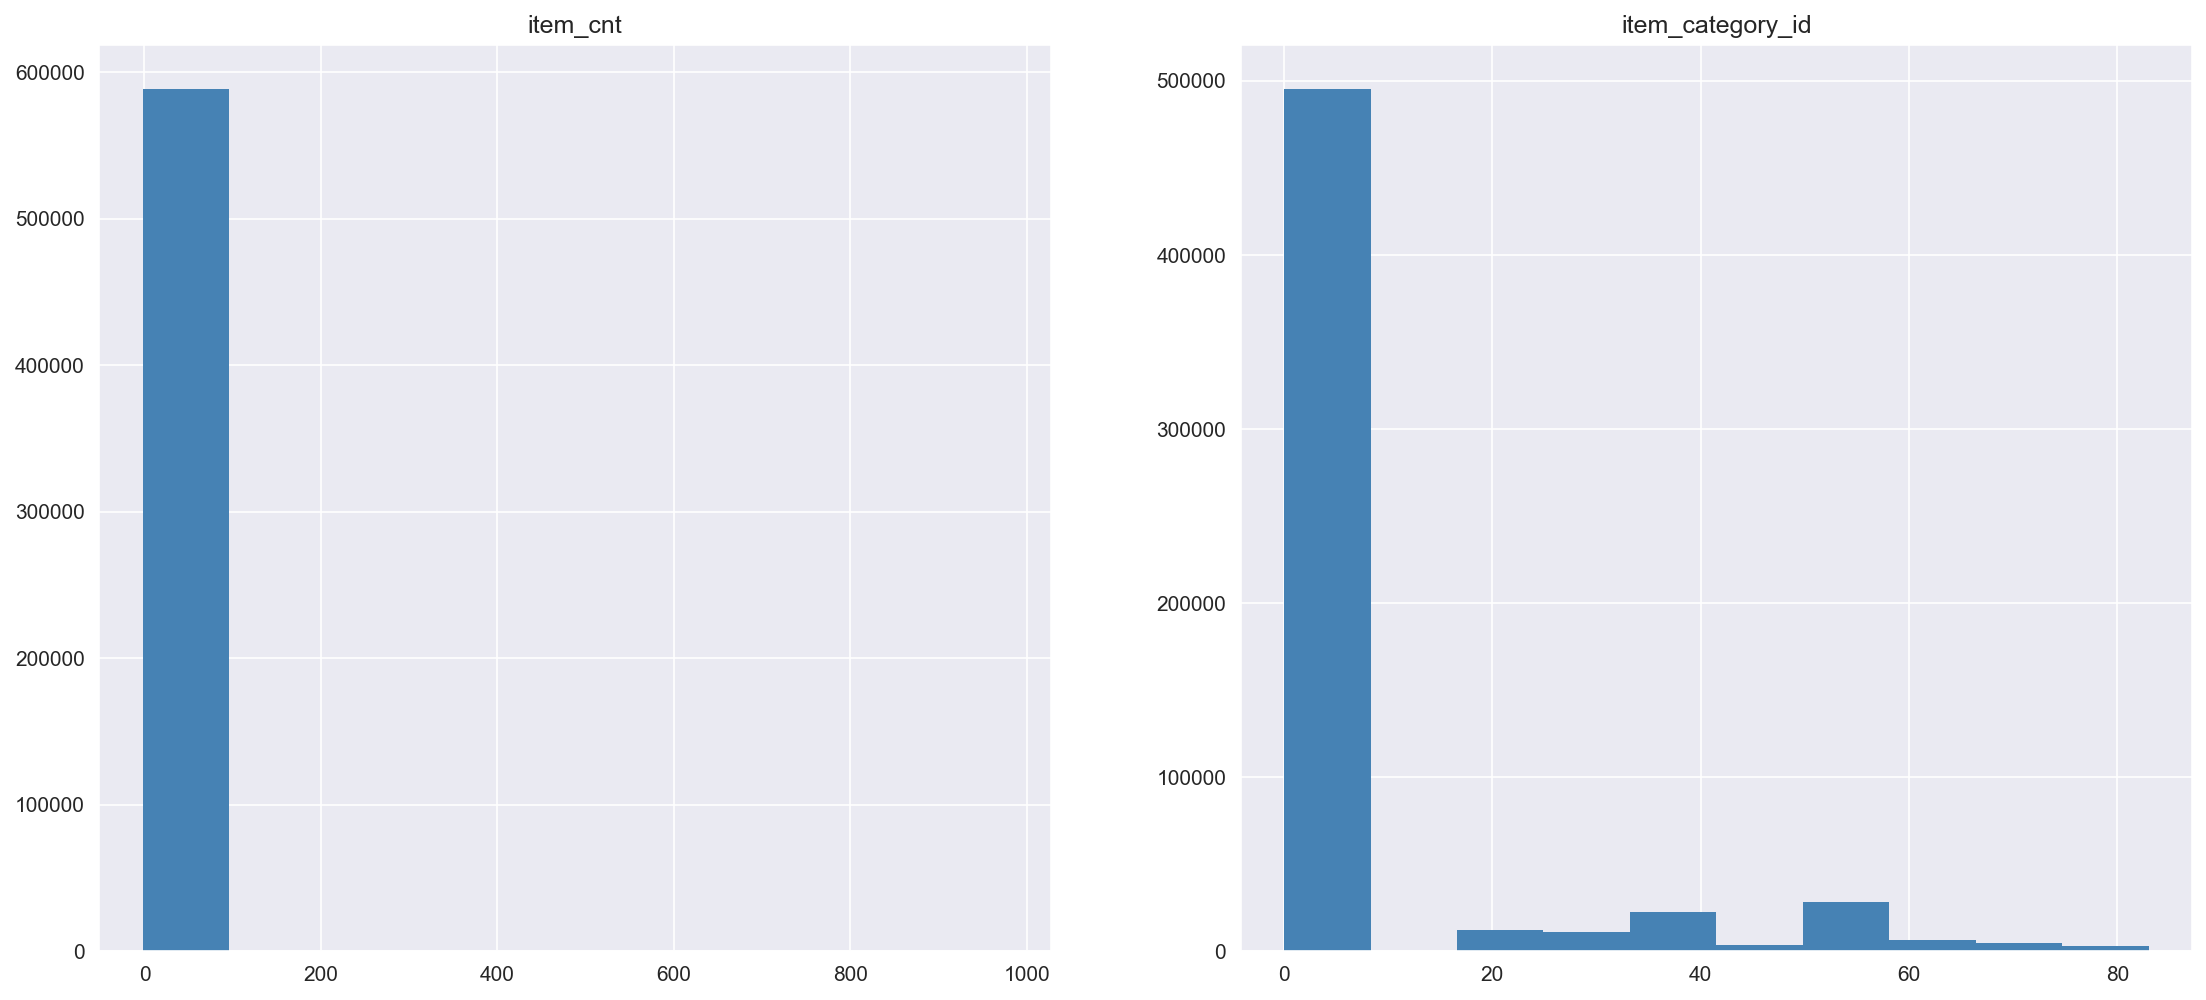

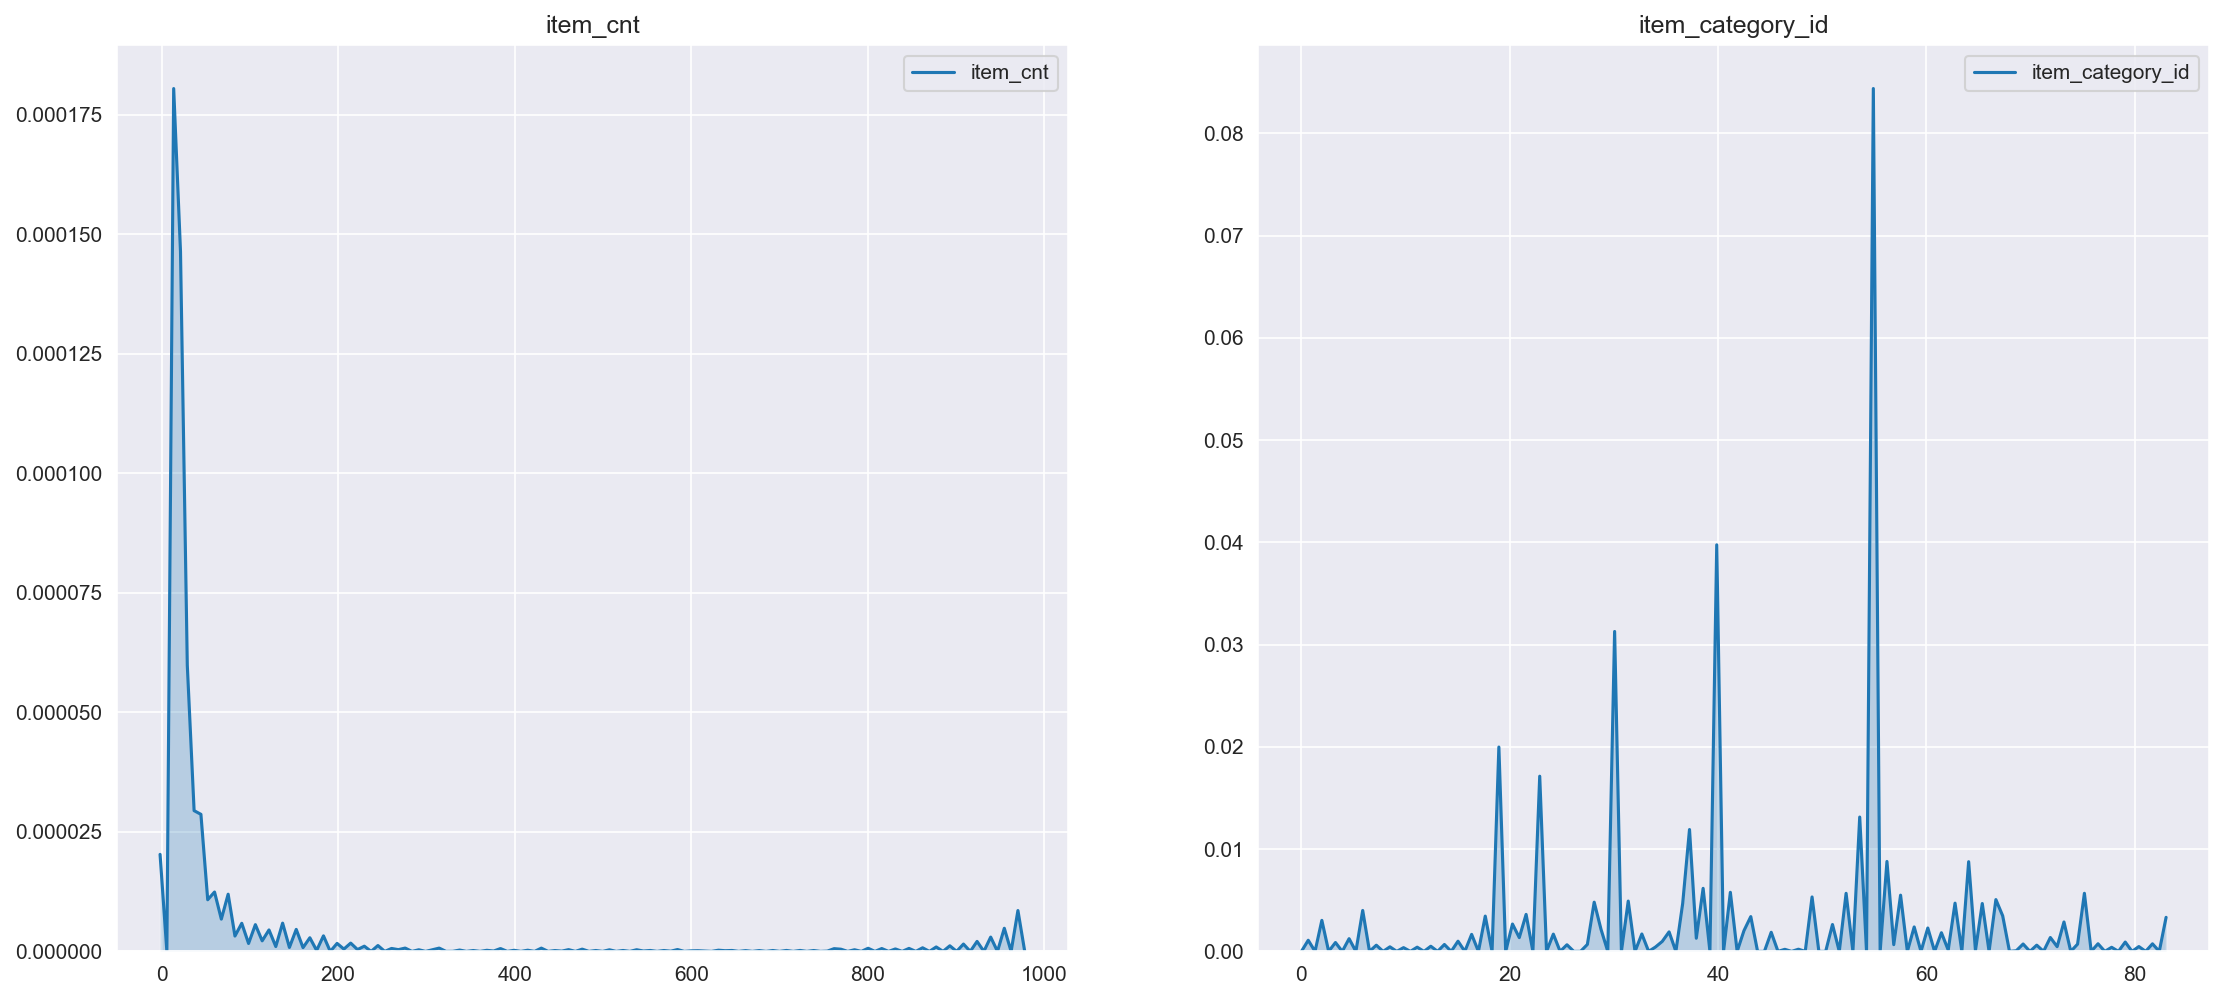

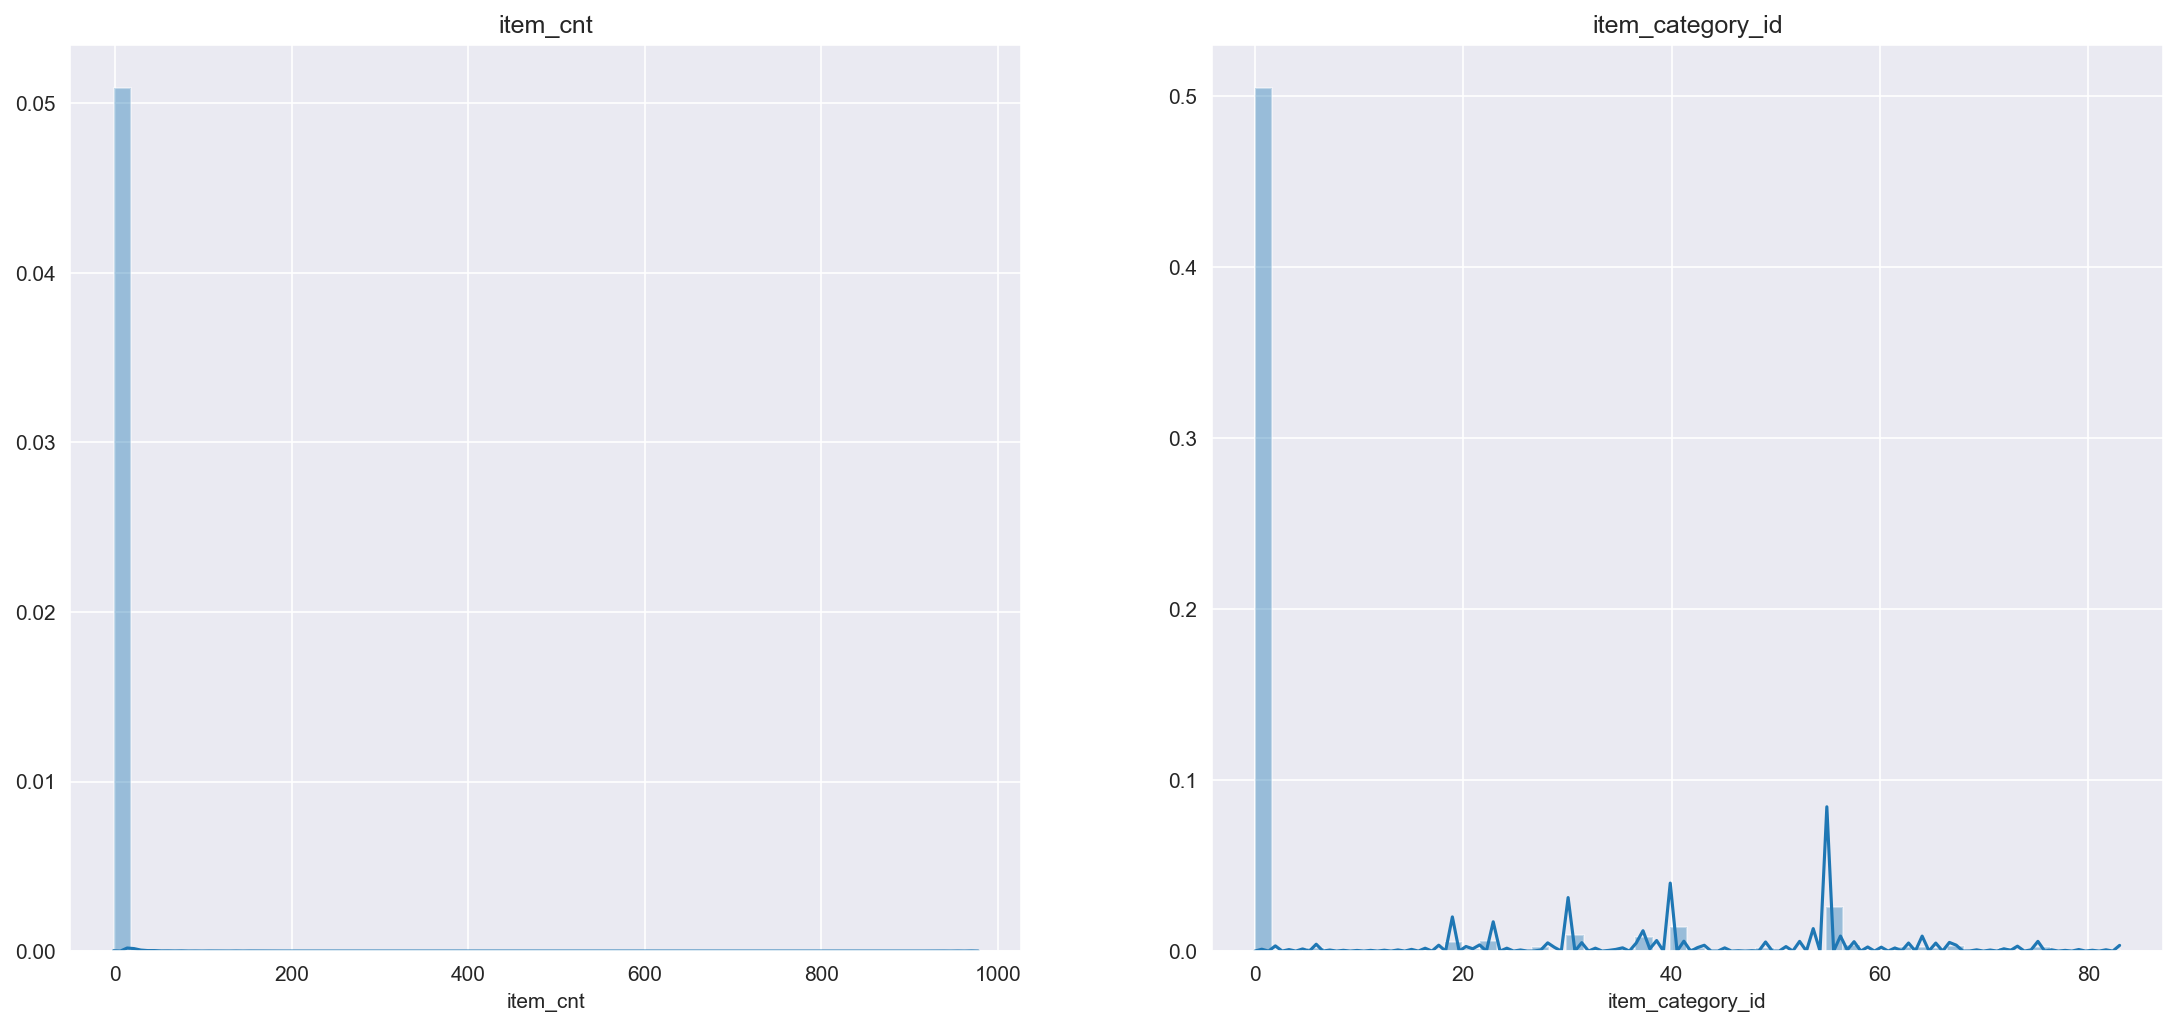

In [34]:
#2.分布分析
#定量数据等分布分析
'''
预得到其分布形式是对称的还是非对称的、发现某些特大或特小的可疑值，可做频率分布表、频率分布直方图、绘制茎叶图进行直观分析。
重点是选择"组数"和"组宽"。
有很多算法的前提假设是数据符合正态分布，例如线性回归里面最小二乘法。因此需要查看数据分布，目标变量是否符合高斯分布。
'''
print('频率分布直方图')
plt.figure(figsize=(18,8), dpi=150)
plt.subplot(1,2,1)
plt.hist(train_monthly['item_cnt'], histtype='stepfilled',color='steelblue',edgecolor='none')
plt.title('item_cnt')
plt.subplot(1,2,2)
plt.hist(train_monthly['item_category_id'],histtype='stepfilled',color='steelblue',edgecolor='none')
plt.title('item_category_id')

plt.figure(figsize=(18,8), dpi=150)
plt.subplot(1,2,1)
sns.kdeplot(train_monthly['item_cnt'], shade=True)  # KDE
plt.title('item_cnt')
plt.subplot(1,2,2)
sns.kdeplot(train_monthly['item_category_id'], shade=True)  # KDE
plt.title('item_category_id')


plt.figure(figsize=(18,8), dpi=150)
plt.subplot(1,2,1)
sns.distplot(train_monthly['item_cnt'])  # KDE
plt.title('item_cnt')
plt.subplot(1,2,2)
sns.distplot(train_monthly['item_category_id'])  # KDE
plt.title('item_category_id')


偏度 2.3298739762241554
峰态 4.100638985801499

 mu = 7.21 and sigma = 17.67



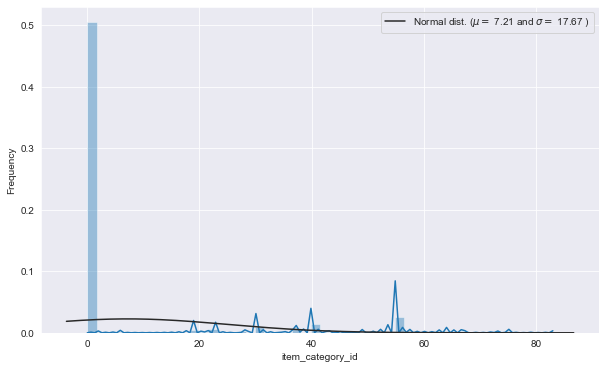

In [35]:
#定性数据等分布分析
#偏度、偏态
print('偏度',train_monthly['item_category_id'].skew())
print('峰态',train_monthly['item_category_id'].kurt())

sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
data =train_monthly['item_category_id'] # 满足高斯分布的10000个数
sns.distplot(data, fit=norm)
(mu, sigma) = norm.fit(data)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency');

In [ ]:
#对比关系描述
'''
对比分析是把两个相互联系的指标进行比较，从数量上展示和说明研究对象规模的大、水平的高低、速度的快慢以及各种关系是否协调。
适合指标间的横纵向对比、时间序列的比较分析。

绝对数对比
绝对数比较分析法直接以数值进行比较，根据差异进行分析。绝对数比较分析法是指将反映企业某一方面的财务指标的绝对值进行对比和分析，通过分析来确定财务指标的增减变动情况。

相对数对比
两个有联系的指标对比计算，用以反映客观现象之间数量联系程度的综合对比。

结构相对数

将同一总体内的部分数值与全部数值进行对比求得比重——产品合格率

说明事物的性质、结构或质量

部分/总体

比例相对数

将同一总体内的不同部分的数值进行对比——人口性别比例、投资

表明总体内各部分的比例关系

一部分/另一部分

比较相对数

同一时期两个性质相同的指标数值进行对比——不同地区的商品价格对比

说明同类现象在不同空间条件下的数量对比关系

A的指标/B的相同指标

强度相对数

将两个性质不同但有一定联系的总量指标进行对比——人口密度（人/平方公里）

说明现象的强度、密度和普遍程度

某总量指标/另一性质不同但关联的总量指标

计划完成程度相对数

将某一时期实际完成数与计划完成数进行对比

说明计划的完成程度

动态相对数

将同一现象在不同时期的指标数值进行对比——发展速度

说明发展方向和变化速度

报告期/基期
'''

In [59]:
#统计分析
'''
平均(mean)
----数是统计学中最常用的统计量，用来表明资料中各观测值相对集中较多的中心位置。
    算术平均数
    ----数据的和与数据个数之比。
    易受极端值的影响，受max的影响程度 > 受min的影响程度

    简单算术平均：所有数据的平均值

    加权算术平均数：反映均值中不同成分的重要程度

    调和平均数(harmonic mean)
    ----变量值倒数的算术平均数的倒数。
    易受极端值的影响，受min的影响 > 受max的影响 调和平均数总小于算术平均数 有一项为0就无法计算H

    简单调和平均：

    加权调和平均数：

    几何平均数(geometric mean)
    ----n个变量值乘积的 n 次方根。
    易受极端值的影响，但受极端值的影响比算术平均数和调和平均数要小, 适用于对比率数据的平均, 主要用于计算平均增长率, 看作是均值的一种变形, 有一项为0就无法计算H

    简单几何平均：

    加权几何平均数：

    幂平均数(power mean)
    ----是毕达哥拉斯平均（包含了算术、几何、调和平均）的一种抽象化。
    是所有平均数的通式, k的递增函数

中位数(Median)
----又称中值，是按顺序排列的一组数据中居于中间位置的数，代表一个样本、种群或概率分布中的一个数值，其可将数值集合划分为相等的上下两部分。
将数据从小到大排列后

众数(Mode)
----指在统计分布上具有明显集中趋势点的数值，代表数据的一般水平。也是一组数据中出现次数最多的数值，有时众数在一组数中有好几个。
离散程度的描述(Dispersion degree)

极差(Range)
----又称范围误差或全距，以R表示，是用来表示统计资料中的变异量数(measures of variation)，其最大值与最小值之间的差距，即最大值减最小值后所得之数据。

方差(variance)
----统计中的方差（样本方差）是每个样本值与全体样本值的平均数之差的平方值的平均数。
标准差( standard deviation, std)
----是离均差平方的算术平均数的算术平方根，用σ表示。最常使用作为统计分布程度上的测量依据。

变异系数（coefficient of variation）
----又称“离散系数”，是概率分布离散程度的一个归一化量度，其定义为标准差与平均值之比。
标准差相对于均值离中趋势  比较具有不同单位和不同波动幅度的数据集的离中趋势。
当需要比较两组数据离散程度大小的时候，如果两组数据的测量尺度相差太大，或者数据量纲的不同，直接使用标准差来进行比较不合适，此时就应当消除测量尺度和量纲的影响，而变异系数可以做到这一点，它是原始数据标准差与原始数据平均数的比。


分位数(Quantile)
----亦称分位点，是指用分割点（cut point，分割点的数量比划分出的区间少1）将一个随机变量的概率分布范围分为几个具有相同概率的连续区间。
q-quantile是指将有限值集分为q个接近相同尺寸的子集。
分位数指的就是连续分布函数中的一个点，这个点对应概率p。

    四分位数（Quartile）
    ----是统计学中分位数的一种，即把所有数值由小到大排列，然后按照总数量分成四等份，即每份中的数值的数量相同，处于三个分割点位置的数值就是四分位数。
    第一四分位数：又称较小四分位数，等于该样本中所有数值由小到大排列后第25%的数字。
    第二四分位数：又称中位数，等于该样本中所有数值由小到大排列后第50%的数字。
    第三四分位数：又称较大四分位数，等于该样本中所有数值由小到大排列后第75%的数字。

    四分位数间距（InterQuartile Range, IQR）
    ----第三四分位数与第一四分位数的差距，值越大说明变异程度越大。四分位距通常是用来构建箱形图，以及对概率分布)的简要图表概述。
'''
mean=train_monthly.mean()
max=train_monthly.max()
min=train_monthly.min()
median=train_monthly.median()
zhongshu=train_monthly.mode().iloc[0]
jicha=max-min
var=train_monthly.var()
std=train_monthly.std()
bianyixishu=std/mean
list_view=train_monthly.describe()
list_view.loc['median']=median
list_view.loc['most']=zhongshu
list_view.loc['jicha']=jicha
list_view.loc['var']=var
list_view.loc['bianyi']=bianyixishu
list_view


,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
count,589040.000000,589040.000000,5.890400e+05,589040.000000,5.890400e+05,589040.000000,589040.000000,589040.000000,589040.000000,589040.0,589040.000000
mean,4.500000,30.351351,1.062441e+04,7.210432,2.615522e+02,107.586693,0.504319,0.178794,0.358607,2013.0,4.500000
std,2.872284,18.191514,6.301691e+03,17.674063,1.516611e+03,389.975861,5.520595,0.541382,1.333879,0.0,2.872284
min,0.000000,2.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,-2.000000,-2.000000,0.000000,2013.0,0.000000
25%,2.000000,15.000000,4.986000e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2013.0,2.000000
50%,4.500000,28.000000,1.076950e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2013.0,4.500000
75%,7.000000,46.000000,1.594375e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2013.0,7.000000
max,9.000000,59.000000,2.216700e+04,83.000000,1.023563e+05,14200.000000,978.000000,115.000000,31.000000,2013.0,9.000000
median,4.500000,28.000000,1.076950e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2013.0,4.500000
most,0.000000,2.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2013.0,0.000000


        item_cnt  item_category_id  shop_id
0            9.0               2.0        2
1            0.0               2.0        2
2            2.0               5.0        2
3            3.0               6.0        2
4            1.0               6.0        2
5            4.0               6.0        2
6            2.0               6.0        2
7            1.0              19.0        2
8            1.0              19.0        2
9            1.0              19.0        2
10           2.0              19.0        2
11           4.0              19.0        2
12           3.0              19.0        2
13           3.0              19.0        2
14           1.0              19.0        2
15           1.0              19.0        2
16           2.0              19.0        2
17           6.0              21.0        2
18           2.0              21.0        2
19           2.0              21.0        2
20           2.0              22.0        2
21           4.0              22

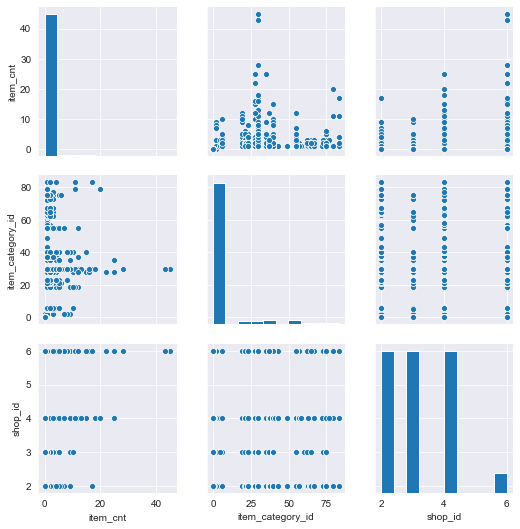

In [67]:
#其他角度分析
'''
周期性分析:探索某个变量是否随着时间的变化而呈现出某种周期变化趋势。

贡献度分析:利用帕累托法则（二八定律）的帕累托分析——同样的投入放在不同的地方会产生不同的效益。

相关性分析:分析连续变量之间是否具有线性相关关系最直观的方法是直接绘制散点图。

直接绘制散点图：绘制点阵矩阵
'''
#点阵矩阵
data=train_monthly[['item_cnt','item_category_id','shop_id']]
print(data)
sns.pairplot(data.iloc[:5000])

In [61]:
#计算相关系数
'''
连续数据，正态分布，线性关系，用pearson相关系数是最恰当，当然用spearman相关系数也可以，效率没有pearson相关系数高。
上述任一条件不满足，就用spearman相关系数，不能用pearson相关系数。
两个定序测量数据（顺序变量）之间也用spearman相关系数，不能用pearson相关系数。
pearson相关系数的一个明显缺陷是，作为特征排序机制，他只对线性关系敏感。如果关系是非线性的，即便两个变量具有一一对应的关系
pearson相关性也可能会接近0。
'''
train_monthly.corr(method='pearson')

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
date_block_num,1.000000e+00,7.209317e-18,-4.094613e-21,0.037794,0.024698,0.028709,0.019620,0.041398,0.031473,NaN,1.000000e+00
shop_id,7.209317e-18,1.000000e+00,-9.379484e-18,0.025128,0.004163,0.005920,0.004295,0.016573,0.017185,NaN,7.209317e-18
item_id,-4.094613e-21,-9.379484e-18,1.000000e+00,-0.013925,-0.081149,-0.101152,-0.007030,-0.042790,-0.052538,NaN,-4.094613e-21
item_category_id,3.779412e-02,2.512808e-02,-1.392522e-02,1.000000,0.282170,0.524009,0.181884,0.686403,0.518401,NaN,3.779412e-02
item_price,2.469811e-02,4.163179e-03,-8.114881e-02,0.282170,1.000000,0.626813,0.337617,0.410958,0.681555,NaN,2.469811e-02
mean_item_price,2.870890e-02,5.919869e-03,-1.011519e-01,0.524009,0.626813,1.000000,0.153111,0.491825,0.428299,NaN,2.870890e-02
item_cnt,1.962041e-02,4.294766e-03,-7.029637e-03,0.181884,0.337617,0.153111,1.000000,0.599404,0.577119,NaN,1.962041e-02
mean_item_cnt,4.139754e-02,1.657318e-02,-4.278973e-02,0.686403,0.410958,0.491825,0.599404,1.000000,0.609583,NaN,4.139754e-02
transactions,3.147326e-02,1.718458e-02,-5.253768e-02,0.518401,0.681555,0.428299,0.577119,0.609583,1.000000,NaN,3.147326e-02
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
